<a href="https://colab.research.google.com/github/ju-ki/atma10/blob/master/exp2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/drive/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
!git clone https://github.com/facebookresearch/fastText.git
!pip install fastText category_encoders xfeat texthero
!rm -rf fastText

Cloning into 'fastText'...
remote: Enumerating objects: 3854, done.
remote: Total 3854 (delta 0), reused 0 (delta 0), pack-reused 3854
Receiving objects: 100% (3854/3854), 8.22 MiB | 26.48 MiB/s, done.
Resolving deltas: 100% (2417/2417), done.


In [3]:
import os 
import glob 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import texthero as hero
from fasttext import load_model
sns.set()
CODE_PATH = "/content/drive/MyDrive/atmacup10/code/"
INPUT_PATH = "/content/drive/MyDrive/atmacup10/data/raw/"
OUTPUT_PAHT = "/content/drive/MyDrive/atmacup10/data/submission/"

In [4]:
train = pd.read_csv(INPUT_PATH + "train.csv")
test = pd.read_csv(INPUT_PATH + "test.csv")
whole_df = pd.concat([train, test])

In [5]:
os.chdir(CODE_PATH)
from util import AbstractBaseBlock
from feature_engine import *
model = load_model("/content/drive/MyDrive/atmacup10/data/external/lid.176.bin")

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [6]:
def cleansing_hero_text(text_col):
  custom_pipeline = [
                   hero.preprocessing.remove_whitespace,
                   hero.preprocessing.drop_no_content,
                   hero.preprocessing.fillna,
                   hero.preprocessing.remove_diacritics,
                   hero.preprocessing.remove_digits,
                   hero.preprocessing.remove_html_tags,
                   hero.preprocessing.remove_urls,
                   hero.preprocessing.remove_brackets,
                   hero.preprocessing.remove_punctuation,
                   hero.preprocessing.stem]
  texts = hero.clean(text_col, custom_pipeline)
  return texts

In [7]:
def get_period_of_production(input_df):
  out_df = pd.DataFrame()
  out_df["period_of_production"] = input_df["dating_year_late"] - input_df["dating_year_early"]
  return out_df

def get_time_between_late_year_and_acqusition(input_df):
  input_df["acquisition_date"] = pd.to_datetime(input_df["acquisition_date"])
  input_df["year"] = input_df["acquisition_date"].dt.year.fillna(0)
  out_df = pd.DataFrame()
  out_df["period_of_acquisition_date"] = input_df["year"]- input_df["dating_year_late"].fillna(0).astype(float)
  return out_df

In [8]:
class GetLanguageLabel(AbstractBaseBlock):
  def __init__(self, cols):
    self.cols = cols

  def fit(self, input_df):
    self.model = load_model("/content/drive/MyDrive/atmacup10/data/external/lid.176.bin")
    return self.transform(input_df)

  def transform(self, input_df):
    out_df = pd.DataFrame()
    out_df[self.cols] = input_df[self.cols].fillna("").map(lambda x: self.model.predict(x.replace("\n", ""))[0][0])
    return out_df.add_prefix("lang_label_")

In [9]:
GetLanguageLabel("title").fit(train)

,lang_label_title
0,__label__en
1,__label__nl
2,__label__nl
3,__label__en
4,__label__nl
...,...
12021,__label__nl
12022,__label__nl
12023,__label__nl
12024,__label__nl


In [10]:
class GetCountString(AbstractBaseBlock):
  def __init__(self, cols):
    self.cols = cols

  def transform(self, input_df):
    out_df = pd.DataFrame()
    out_df[self.cols] = input_df[self.cols].str.len().fillna("")
    return out_df.add_prefix("count_string_")

In [11]:
# GetCountString("title").fit(train)

In [12]:
class GetCountWord(AbstractBaseBlock):
  def __init__(self, cols):
    self.cols = cols

  def transform(self, input_df):
    out_df = pd.DataFrame()
    out_df[self.cols] = cleansing_hero_text(input_df[self.cols])
    out_df[self.cols] = out_df[self.cols].apply(lambda x: len(x.split())).fillna("")
    return out_df.add_prefix("count_word_")

In [13]:
GetCountWord("description").fit(train).isnull().sum()

count_word_description    0
dtype: int64

In [14]:
class LabelEncodingBlock(AbstractBaseBlock):
  def __init__(self, cols):
    self.cols = cols

  def fit(self, input_df, y=None):
    self.encoder = ce.OrdinalEncoder()
    return self.transform(input_df)

  def transform(self, input_df):
    out_df = pd.DataFrame()
    out_df = self.encoder.fit_transform(input_df[self.cols]).add_prefix("LE_")
    return out_df

In [15]:
LabelEncodingBlock("acquisition_method").fit(train)

,LE_acquisition_method
0,1
1,1
2,2
3,3
4,4
...,...
12021,5
12022,1
12023,5
12024,1


In [16]:
train[["title", "long_title"]]

,title,long_title
0,The Avenue of Birches,"The Avenue of Birches, Jan Hackaert, 1660 - 1685"
1,Struik in bloei,"Struik in bloei, Richard Tepe (attributed to),..."
2,Portret van een vrouw,"Portret van een vrouw, Tresling & Comp., 1860 ..."
3,A St Bernard Dog,"A St Bernard Dog, Bernard te Gempt, c. 1850 - ..."
4,Woelige zee met zeilschepen,"Woelige zee met zeilschepen, anonymous, 1825 -..."
...,...,...
12021,De schilder H.W. Mesdag voor een doek,"De schilder H.W. Mesdag voor een doek, Delboy ..."
12022,"Kaart van de streek tussen Mannheim en Landau,...","Kaart van de streek tussen Mannheim en Landau,..."
12023,Storm op het IJ aan het Blauwhoofd van Amsterd...,Storm op het IJ aan het Blauwhoofd van Amsterd...
12024,"Het rad van fortuin, ca. 1689","Het rad van fortuin, ca. 1689, Romeyn de Hoogh..."


In [17]:
from nltk.util import ngrams

def line_ngram(line, n=2):
  words = [w for w in line.split(' ') if len(w) != 0]
  return list(ngrams(words, n))

In [18]:
def create_n_gram(x, n=3):
  x = cleansing_hero_text(x)
  x = pd.Series(x).map(lambda r: line_ngram(r, n=n))
  return x

class NameNGramBlock(AbstractBaseBlock):
    def __init__(self, whole_df, col, n=3):
        self.whole_df = whole_df
        self.col = col
        self.n = n

    def fit(self, input_df, y=None):
        name_grams = create_n_gram(self.whole_df[self.col], n=self.n)
        grams = [x for row in name_grams for x in row if len(x) > 0]
        top_grams = pd.Series(grams).value_counts().head(20).index

        self.top_grams_ = top_grams
        return self.transform(input_df)

    def transform(self, input_df):
        name_grams = create_n_gram(input_df[self.col], n=self.n)
        output_df = pd.DataFrame()

        for top in self.top_grams_:
            s_top = '-'.join(top)
            output_df[f'{s_top}'] = name_grams.map(lambda x: top in x).map(int)

        return output_df.add_prefix('Name_has_').add_suffix(f'_n={self.n}')

In [19]:
NameNGramBlock(train, "title", n=3).fit(train)

,Name_has_portret-van-een_n=3,Name_has_van-een-onbekend_n=3,Name_has_gezicht-op-de_n=3,Name_has_een-onbekend-vrouw_n=3,Name_has_gezicht-op-het_n=3,Name_has_een-onbekend-man_n=3,Name_has_gezicht-op-een_n=3,Name_has_portrait-of-a_n=3,Name_has_fotoreproducti-van-een_n=3,Name_has_portret-van-de_n=3,Name_has_van-een-vrouw_n=3,Name_has_van-een-man_n=3,Name_has_still-life-with_n=3,Name_has_interieur-van-de_n=3,Name_has_op-de-achtergrond_n=3,Name_has_op-de-voorgrond_n=3,Name_has_of-a-man_n=3,Name_has_van-een-schilderij_n=3,Name_has_een-onbekend-jong_n=3,Name_has_studi-van-een_n=3
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12021,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12022,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12023,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12024,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [20]:
from time import time
from tqdm import tqdm
from contextlib import contextmanager

def get_function(block,is_train):
    s = mapping ={
        True:'fit',
        False:'transform'
    }.get(is_train)
    return getattr(block,s)

def to_feature(input_df,remain_df,blocks,is_train=False):
    out_df = remain_df
    
    for block in tqdm(blocks,total=len(blocks)):
        func = get_function(block,is_train)
        
        with timer(prefix='create' + str(block) + ' '):
            _df = func(input_df)
        print(len(_df), len(input_df))
        assert len(_df) == len(input_df),func._name_
        out_df = pd.concat([out_df,_df],axis=1)
    return out_df

@contextmanager
def timer(logger=None, format_str="{:.3f}[s]", prefix=None, suffix=None):
  if prefix: format_str = str(prefix) + format_str
  if suffix: format_str = format_str + str(suffix)
  start = time()
  yield
  d = time() - start
  out_str = format_str.format(d)
  if logger:
    logger.info(out_str)
  else:
    print(out_str)

In [21]:
class WrapperBlock(AbstractBaseBlock):
    def __init__(self, function):
        self.function = function
        
    def transform(self, input_df):
        return self.function(input_df)

In [22]:
add_feature_block = [
                     WrapperBlock(get_period_of_production),
                     WrapperBlock(get_time_between_late_year_and_acqusition),
                     GetLanguageLabel("title"),
                     GetLanguageLabel("description"),
                     GetCountString("title"),
                     GetCountWord("title"),
                    #  GetCountString("description"),
                    #  GetCountWord("description"),
                    #  GetCountString("acquisition_credit_line"),
                    #  GetCountWord("acquisition_credit_line")
]

In [23]:
drop_columns = ["object_id", "art_series_id", "long_title", ]
train_meta_df = to_feature(train, train.drop(columns=drop_columns, axis=1), add_feature_block, is_train=True)
test_meta_df = to_feature(test, test.drop(columns=drop_columns, axis=1), add_feature_block, is_train=False)

  0%|          | 0/6 [00:00<?, ?it/s]Warning : `load_model` does not return WordVectorModel or SupervisedModel any more, but a `FastText` object which is very similar.


create<__main__.WrapperBlock object at 0x7f0eaf9db090> 0.013[s]
12026 12026
create<__main__.WrapperBlock object at 0x7f0eaf9db050> 0.011[s]
12026 12026


 50%|█████     | 3/6 [00:00<00:00,  5.93it/s]

create<__main__.GetLanguageLabel object at 0x7f0eaf8b2fd0> 0.469[s]
12026 12026


 67%|██████▋   | 4/6 [00:01<00:00,  2.94it/s]

create<__main__.GetLanguageLabel object at 0x7f0eaf8b2c10> 0.728[s]
12026 12026
create<__main__.GetCountString object at 0x7f0eaf8b2bd0> 0.010[s]
12026 12026


  0%|          | 0/6 [00:00<?, ?it/s]

create<__main__.GetCountWord object at 0x7f0eaf8b2e10> 1.175[s]
12026 12026
create<__main__.WrapperBlock object at 0x7f0eaf9db090> 0.004[s]
12008 12008
create<__main__.WrapperBlock object at 0x7f0eaf9db050> 0.011[s]
12008 12008


 50%|█████     | 3/6 [00:00<00:00, 11.50it/s]

create<__main__.GetLanguageLabel object at 0x7f0eaf8b2fd0> 0.236[s]
12008 12008


 67%|██████▋   | 4/6 [00:00<00:00,  4.95it/s]

create<__main__.GetLanguageLabel object at 0x7f0eaf8b2c10> 0.461[s]
12008 12008
create<__main__.GetCountString object at 0x7f0eaf8b2bd0> 0.008[s]
12008 12008


100%|██████████| 6/6 [00:02<00:00,  2.84it/s]

create<__main__.GetCountWord object at 0x7f0eaf8b2e10> 1.347[s]
12008 12008


In [24]:
process_blocks = [
                #  WrapperBlock(get_period_of_production),
                #  WrapperBlock(get_time_between_late_year_and_acqusition),
                #  GetLanguageLabel("title"),
                #  GetLanguageLabel("description"),
                #  GetCountString("title"),
                #  GetCountWord("title"),
                #  GetCountString("description"),
                #  GetCountWord("description"),
                #  GetCountString("acquisition_credit_line"),
                #  GetCountWord("acquisition_credit_line"),
                 LabelEncodingBlock("acquisition_method"),
                 LabelEncodingBlock("principal_maker"),
                 LabelEncodingBlock("lang_label_title"),
                 LabelEncodingBlock("lang_label_description"),
                 LabelEncodingBlock("title"),
                 LabelEncodingBlock("description"),
                 CountEncodingBlock("acquisition_method"),
                 CountEncodingBlock("principal_maker"),
                 CountEncodingBlock("lang_label_title"),
                 CountEncodingBlock("lang_label_description"),
                 CountEncodingBlock("title"),
                 CountEncodingBlock("description"),
                 AggregationBlock(group_key="acquisition_method",
                                  group_values=["dating_period", "count_string_title", "count_word_title", "period_of_production", "period_of_acquisition_date"],
                                  agg_methods=["max", "min", "std", "median", max_min, q75_q25]),
                 AggregationBlock(group_key="principal_maker",
                                  group_values=["dating_period", "count_string_title", "count_word_title", "period_of_production", "period_of_acquisition_date"],
                                  agg_methods=["max", "min", "std", "median", max_min, q75_q25]),
                 AggregationBlock(group_key="lang_label_title",
                                  group_values=["dating_period", "count_string_title", "count_word_title", "period_of_production", "period_of_acquisition_date"],
                                  agg_methods=["max", "min", "std", "median", max_min, q75_q25]),
                 NameNGramBlock(whole_df, "title", n=2),
                 
]

In [25]:
drop_columns = ["description", "title", "principal_maker", "principal_or_first_maker",
                  "sub_title", "copyright_holder", "more_title", "acquisition_credit_line", "dating_presenting_date",
                  "dating_sorting_date", "acquisition_date", "acquisition_method", "lang_label_title", "lang_label_description"]
train_feat_df = to_feature(train_meta_df,train_meta_df.drop(columns=drop_columns, axis=1),process_blocks, is_train=True)

test_feat_df = to_feature(test_meta_df,test_meta_df.drop(columns=drop_columns, axis=1),process_blocks,is_train=False)

 44%|████▍     | 7/16 [00:00<00:00, 65.04it/s]

create<__main__.LabelEncodingBlock object at 0x7f0eafe01bd0> 0.011[s]
12026 12026
create<__main__.LabelEncodingBlock object at 0x7f0eafe01850> 0.011[s]
12026 12026
create<__main__.LabelEncodingBlock object at 0x7f0eafe018d0> 0.010[s]
12026 12026
create<__main__.LabelEncodingBlock object at 0x7f0eaf9bff50> 0.009[s]
12026 12026
create<__main__.LabelEncodingBlock object at 0x7f0eaf9bff10> 0.019[s]
12026 12026
create<__main__.LabelEncodingBlock object at 0x7f0eafba4350> 0.015[s]
12026 12026
create<feature_engine.CountEncodingBlock object at 0x7f0eafba4390> 0.008[s]
12026 12026
create<feature_engine.CountEncodingBlock object at 0x7f0eafba43d0> 0.009[s]
12026 12026
create<feature_engine.CountEncodingBlock object at 0x7f0eafba4210> 0.009[s]
12026 12026
create<feature_engine.CountEncodingBlock object at 0x7f0eafba4290> 0.010[s]
12026 12026
create<feature_engine.CountEncodingBlock object at 0x7f0eafba42d0> 0.012[s]
12026 12026
create<feature_engine.CountEncodingBlock object at 0x7f0eafba4310> 0

 81%|████████▏ | 13/16 [00:00<00:00, 28.27it/s]

create<feature_engine.AggregationBlock object at 0x7f0eafba4090> 0.400[s]
12026 12026
create<feature_engine.AggregationBlock object at 0x7f0eafba4150> 14.324[s]
12026 12026


 94%|█████████▍| 15/16 [00:15<00:02,  2.26s/it]

create<feature_engine.AggregationBlock object at 0x7f0eafba4190> 0.541[s]
12026 12026


  0%|          | 0/16 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead

 44%|████▍     | 7/16 [00:00<00:00, 69.21it/s]

create<__main__.NameNGramBlock object at 0x7f0eafba41d0> 4.189[s]
12026 12026
create<__main__.LabelEncodingBlock object at 0x7f0eafe01bd0> 0.013[s]
12008 12008
create<__main__.LabelEncodingBlock object at 0x7f0eafe01850> 0.011[s]
12008 12008
create<__main__.LabelEncodingBlock object at 0x7f0eafe018d0> 0.009[s]
12008 12008
create<__main__.LabelEncodingBlock object at 0x7f0eaf9bff50> 0.009[s]
12008 12008
create<__main__.LabelEncodingBlock object at 0x7f0eaf9bff10> 0.017[s]
12008 12008
create<__main__.LabelEncodingBlock object at 0x7f0eafba4350> 0.014[s]
12008 12008
create<feature_engine.CountEncodingBlock object at 0x7f0eafba4390> 0.007[s]
12008 12008
create<feature_engine.CountEncodingBlock object at 0x7f0eafba43d0> 0.010[s]
12008 12008
create<feature_engine.CountEncodingBlock object at 0x7f0eafba4210> 0.008[s]
12008 12008
create<feature_engine.CountEncodingBlock object at 0x7f0eafba4290> 0.008[s]
12008 12008
create<feature_engine.CountEncodingBlock object at 0x7f0eafba42d0> 0.012[s]
12

 81%|████████▏ | 13/16 [00:00<00:00, 29.21it/s]

create<feature_engine.AggregationBlock object at 0x7f0eafba4090> 0.397[s]
12008 12008
create<feature_engine.AggregationBlock object at 0x7f0eafba4150> 14.780[s]
12008 12008


 94%|█████████▍| 15/16 [00:15<00:02,  2.33s/it]

create<feature_engine.AggregationBlock object at 0x7f0eafba4190> 0.588[s]
12008 12008


100%|██████████| 16/16 [00:17<00:00,  1.10s/it]

create<__main__.NameNGramBlock object at 0x7f0eafba41d0> 1.658[s]
12008 12008


In [26]:
train_feat_df

,dating_period,dating_year_early,dating_year_late,likes,period_of_production,period_of_acquisition_date,count_string_title,count_word_title,LE_acquisition_method,LE_principal_maker,LE_lang_label_title,LE_lang_label_description,LE_title,LE_description,CE_acquisition_method,CE_principal_maker,CE_lang_label_title,CE_lang_label_description,CE_title,CE_description,agg_max_dating_period_grpby_acquisition_method,agg_max_count_string_title_grpby_acquisition_method,agg_max_count_word_title_grpby_acquisition_method,agg_max_period_of_production_grpby_acquisition_method,agg_max_period_of_acquisition_date_grpby_acquisition_method,agg_min_dating_period_grpby_acquisition_method,agg_min_count_string_title_grpby_acquisition_method,agg_min_count_word_title_grpby_acquisition_method,agg_min_period_of_production_grpby_acquisition_method,agg_min_period_of_acquisition_date_grpby_acquisition_method,agg_std_dating_period_grpby_acquisition_method,agg_std_count_string_title_grpby_acquisition_method,agg_std_count_word_title_grpby_acquisition_method,agg_std_period_of_production_grpby_acquisition_method,agg_std_period_of_acquisition_date_grpby_acquisition_method,agg_median_dating_period_grpby_acquisition_method,agg_median_count_string_title_grpby_acquisition_method,agg_median_count_word_title_grpby_acquisition_method,agg_median_period_of_production_grpby_acquisition_method,agg_median_period_of_acquisition_date_grpby_acquisition_method,...,agg_std_dating_period_grpby_lang_label_title,agg_std_count_string_title_grpby_lang_label_title,agg_std_count_word_title_grpby_lang_label_title,agg_std_period_of_production_grpby_lang_label_title,agg_std_period_of_acquisition_date_grpby_lang_label_title,agg_median_dating_period_grpby_lang_label_title,agg_median_count_string_title_grpby_lang_label_title,agg_median_count_word_title_grpby_lang_label_title,agg_median_period_of_production_grpby_lang_label_title,agg_median_period_of_acquisition_date_grpby_lang_label_title,agg_<function max_min at 0x7f0ebd65f320>_dating_period_grpby_lang_label_title,agg_<function max_min at 0x7f0ebd65f320>_count_string_title_grpby_lang_label_title,agg_<function max_min at 0x7f0ebd65f320>_count_word_title_grpby_lang_label_title,agg_<function max_min at 0x7f0ebd65f320>_period_of_production_grpby_lang_label_title,agg_<function max_min at 0x7f0ebd65f320>_period_of_acquisition_date_grpby_lang_label_title,agg_<function q75_q25 at 0x7f0eb0dc5170>_dating_period_grpby_lang_label_title,agg_<function q75_q25 at 0x7f0eb0dc5170>_count_string_title_grpby_lang_label_title,agg_<function q75_q25 at 0x7f0eb0dc5170>_count_word_title_grpby_lang_label_title,agg_<function q75_q25 at 0x7f0eb0dc5170>_period_of_production_grpby_lang_label_title,agg_<function q75_q25 at 0x7f0eb0dc5170>_period_of_acquisition_date_grpby_lang_label_title,Name_has_portret-van_n=2,Name_has_van-een_n=2,Name_has_van-de_n=2,Name_has_gezicht-op_n=2,Name_has_op-de_n=2,Name_has_een-onbekend_n=2,Name_has_portrait-of_n=2,Name_has_in-de_n=2,Name_has_of-the_n=2,Name_has_van-het_n=2,Name_has_op-een_n=2,Name_has_in-een_n=2,Name_has_met-een_n=2,Name_has_op-het_n=2,Name_has_in-het_n=2,Name_has_aan-de_n=2,Name_has_onbekend-vrouw_n=2,Name_has_bij-een_n=2,Name_has_fotoreproducti-van_n=2,Name_has_en-de_n=2
0,17,1660.0,1685.0,48,25.0,123.0,21,4,1,1,1,1,1,1,4253,3,2342,3529,1,3520,21.0,260.0,41.0,113.0,2000.0,-2.0,4.0,1.0,0.0,-30.0,1.295763,25.893399,4.106748,19.016250,138.371159,18.0,37.0,6.0,2.0,173.0,...,1.182309,31.012115,4.609841,18.563911,291.497675,17.0,30.0,5.0,3.0,165.0,8,449,60,199.0,3874.0,2.0,32.0,5.0,20.0,151.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,19,1900.0,1930.0,2,30.0,70.0,15,3,1,2,2,1,2,1,4253,180,9090,3529,1,3520,21.0,260.0,41.0,113.0,2000.0,-2.0,4.0,1.0,0.0,-30.0,1.295763,25.893399,4.106748,19.016250,138.371159,18.0,37.0,6.0,2.0,173.0,...,1.375469,25.339739,4.002880,18.759616,578.827412,19.0,41.0,6.0,4.0,113.0,23,264,40,200.0,3928.0,2.0,29.0,5.0,20.0,110.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,19,1860.0,1880.0,5,20.0,127.0,21,4,2,3,2,2

In [27]:
train_feat_df = train_feat_df.drop(columns=["likes"], axis=1)

In [28]:
y = np.log1p(train["likes"])

In [29]:
from sklearn.metrics import mean_squared_error
import lightgbm as lgbm
def fit_lgbm(X,
             y,
             cv, 
             params: dict=None,
             verbose: int=50):
    
    metric_func = mean_squared_error
    
    if params is None:
        params = {}
        
    models = []
    
    oof_pred = np.zeros_like(y ,dtype=np.float)
    
    for i, (idx_train, idx_valid) in enumerate(cv):
        x_train, x_valid = X[idx_train], X[idx_valid]
        y_train, y_valid = y[idx_train], y[idx_valid]
        
        clf = lgbm.LGBMRegressor(**params)
        
        with timer(prefix="fit fold={}".format(i + 1)):
            clf.fit(x_train, y_train, 
                    eval_set=[(x_valid, y_valid)],
                    early_stopping_rounds=verbose,
                    verbose=verbose)
            
        pred_i = clf.predict(x_valid)
        
        oof_pred[idx_valid] = pred_i
        models.append(clf)
        
        print(f'K Fold {i} RMSLE: {metric_func(y_valid, pred_i) ** .5:.4f}')
        
    score = metric_func(y, oof_pred) ** .5
    print('FINIHED | Whole RMSLE: {:.4f}'.format(score))
    return oof_pred, models

In [30]:
params = {
    "objective": "rmse",
    "max_depth": 7,
    "n_estimators": 10000,
    "learning_rate": 0.01,
    "colsample_bytree": .5,
    "importance_type": "gain",
}

In [31]:
from sklearn.model_selection import KFold

fold = KFold(n_splits=5, shuffle=True, random_state=71)
cv = list(fold.split(train_feat_df, y))

In [32]:
oof, models = fit_lgbm(train_feat_df.values, y, cv, params=params, verbose=500)

Training until validation scores don't improve for 500 rounds.
[500]	valid_0's rmse: 1.1327
[1000]	valid_0's rmse: 1.12108
[1500]	valid_0's rmse: 1.11422
[2000]	valid_0's rmse: 1.11092
[2500]	valid_0's rmse: 1.11028
[3000]	valid_0's rmse: 1.11044
Early stopping, best iteration is:
[2711]	valid_0's rmse: 1.10996
fit fold=115.146[s]
K Fold 0 RMSLE: 1.1100
Training until validation scores don't improve for 500 rounds.
[500]	valid_0's rmse: 1.12561
[1000]	valid_0's rmse: 1.10775
[1500]	valid_0's rmse: 1.10015
[2000]	valid_0's rmse: 1.09572
[2500]	valid_0's rmse: 1.09323
[3000]	valid_0's rmse: 1.09328
[3500]	valid_0's rmse: 1.09303
[4000]	valid_0's rmse: 1.09331
Early stopping, best iteration is:
[3599]	valid_0's rmse: 1.09269
fit fold=219.060[s]
K Fold 1 RMSLE: 1.0927
Training until validation scores don't improve for 500 rounds.
[500]	valid_0's rmse: 1.11322
[1000]	valid_0's rmse: 1.09598
[1500]	valid_0's rmse: 1.08797
[2000]	valid_0's rmse: 1.08371
[2500]	valid_0's rmse: 1.08101
[3000]	v

In [33]:

def visualize_importance(models, feat_train_df):
    """lightGBM の model 配列の feature importance を plot する
    CVごとのブレを boxen plot として表現します.

    args:
        models:
            List of lightGBM models
        feat_train_df:
            学習時に使った DataFrame
    """
    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df['feature_importance'] = model.feature_importances_
        _df['column'] = feat_train_df.columns
        _df['fold'] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df], 
                                          axis=0, ignore_index=True)

    order = feature_importance_df.groupby('column')\
        .sum()[['feature_importance']]\
        .sort_values('feature_importance', ascending=False).index[:50]

    fig, ax = plt.subplots(figsize=(8, max(6, len(order) * .25)))
    sns.boxenplot(data=feature_importance_df, 
                  x='feature_importance', 
                  y='column', 
                  order=order, 
                  ax=ax, 
                  palette='viridis', 
                  orient='h')
    ax.tick_params(axis='x', rotation=90)
    ax.set_title('Importance')
    ax.grid()
    return fig, ax

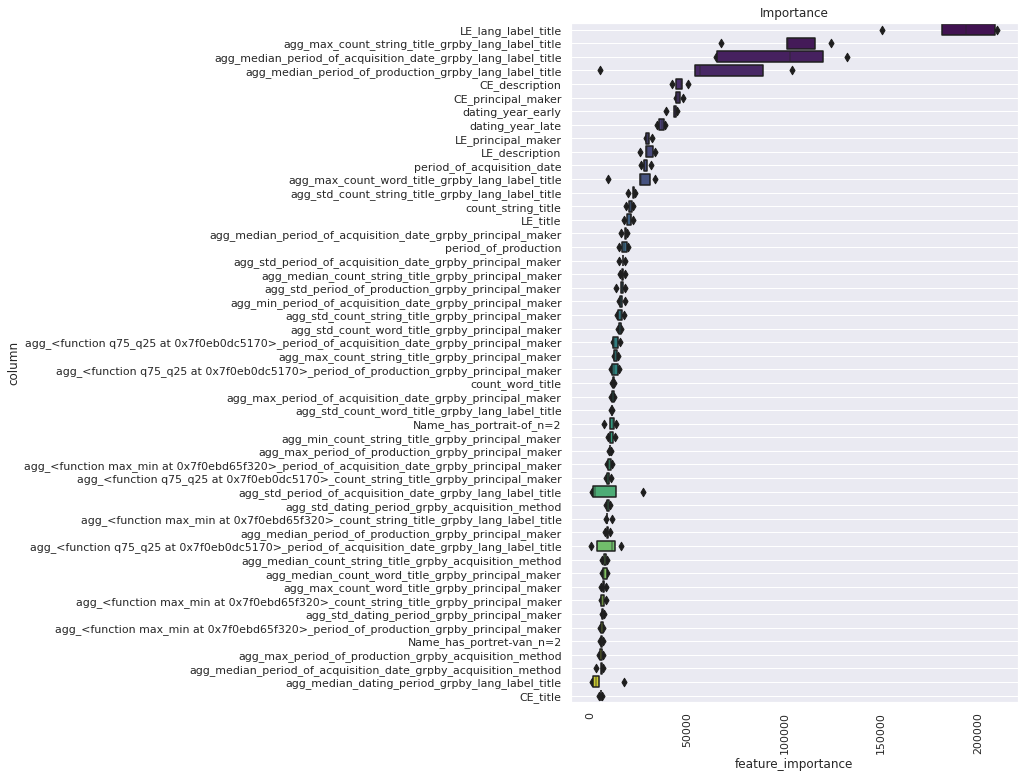

In [34]:
fig, _ = visualize_importance(models, feat_train_df=train_feat_df)

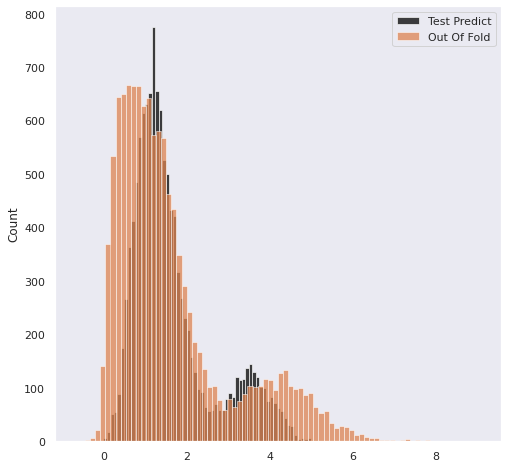

In [35]:
def revert_to_real(y_log):
    _pred = np.expm1(y_log)
    _pred = np.where(_pred < 0, 0, _pred)
    return _pred
pred = np.array([model.predict(test_feat_df.values) for model in models])
pred = np.mean(pred, axis=0)
pred = revert_to_real(pred)
sub_df = pd.DataFrame({ 'likes': pred })
fig, ax = plt.subplots(figsize=(8, 8))
sns.histplot(np.log1p(pred), label='Test Predict', ax=ax, color='black')
sns.histplot(oof, label='Out Of Fold', ax=ax, color='C1')
ax.legend()
ax.grid()

In [37]:
sub_df.to_csv(os.path.join(OUTPUT_PAHT, 'add_2_gram.csv'), index=False)